In [5]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [6]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join("C:\\Users\\Deepak Sawant\\Downloads\\archive\\Training",label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join("C:\\Users\\Deepak Sawant\\Downloads\\archive\\Testing",label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:02<00:00, 123.05it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


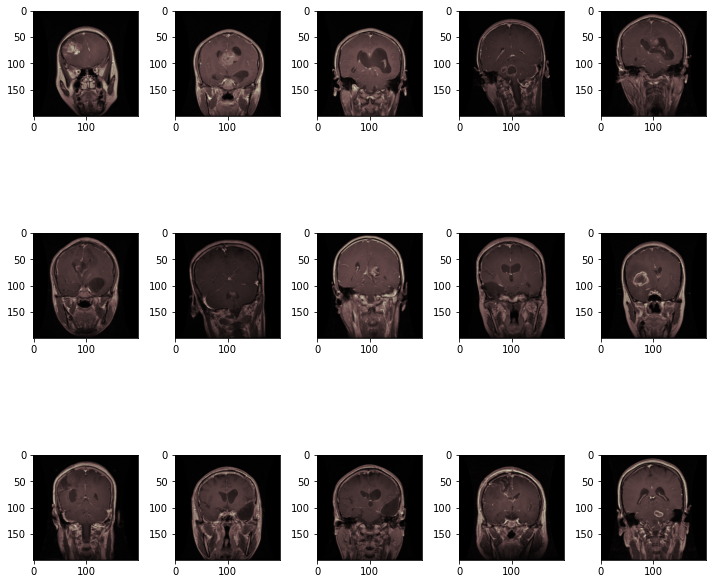

In [7]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [8]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [15]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [13]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

In [16]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
%tensorboard --logdir logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


Reusing TensorBoard on port 6006 (pid 12060), started 6 days, 3:19:20 ago. (Use '!kill 12060' to kill it.)

In [ ]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8925
Epoch 1: val_loss improved from inf to 5.98613, saving model to model-01-0.28-5.99.h5
229/229 [==============================] - 1588s 7s/step - loss: 0.2890 - accuracy: 0.8925 - val_loss: 5.9861 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9591
Epoch 2: val_loss improved from 5.98613 to 1.99166, saving model to model-02-0.32-1.99.h5
229/229 [==============================] - 1609s 7s/step - loss: 0.1340 - accuracy: 0.9591 - val_loss: 1.9917 - val_accuracy: 0.3246 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9744
Epoch 3: val_loss did not improve from 1.99166
229/229 [==============================] - 1578s 7s/step - loss: 0.0800 - accuracy: 0.9744 - val_loss: 4.1574 - val_accuracy: 0.3832 - lr: 1.0000e-04
Epoch 4/50
229/229 [===================

In [18]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>